In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import models, datasets
import torchvision.transforms as transforms
from torchsummary import summary
from torchvision import models, datasets
from torch.utils.data import Dataset , DataLoader, random_split, WeightedRandomSampler, ConcatDataset
from time import time

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using:', device)

Using: cpu


In [3]:
train_img_path = 'deep-learning-for-msc-coursework-2022/train/train/'
test_img_path = 'deep-learning-for-msc-coursework-2022/test'

mean = torch.tensor([0.5, 0.5, 0.5], dtype=torch.float32)
std = torch.tensor([0.5, 0.5, 0.5], dtype=torch.float32)

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

dataset_train = torchvision.datasets.ImageFolder(train_img_path, transform= transform)
dataset_test = torchvision.datasets.ImageFolder(test_img_path, transform= transform)

#The picture in Cancer folder corresponds to label 0, Connective corresponds to 1, Immune corresponds to 2, Normal corresponds to 3, 
print("Train dataset class mapping: ",dataset_train.class_to_idx)


Train dataset class mapping:  {'Cancer': 0, 'Connective': 1, 'Immune': 2, 'Normal': 3}


In [4]:
df_train = pd.DataFrame(dataset_train.imgs)

In [5]:
target_classes = dataset_train.class_to_idx
target_classes
target = {y:x for x,y in target_classes.items()}
target

{0: 'Cancer', 1: 'Connective', 2: 'Immune', 3: 'Normal'}

In [6]:
df_train = df_train.rename(columns={0:"Img_path",1:"Type"})
df_train['Id'] = range(1, 1+len(df_train))
df_train['label'] = df_train['Type'].map(target)

In [7]:
df_train.head()

,Img_path,Type,Id,label
0,deep-learning-for-msc-coursework-2022/train/tr...,0,1,Cancer
1,deep-learning-for-msc-coursework-2022/train/tr...,0,2,Cancer
2,deep-learning-for-msc-coursework-2022/train/tr...,0,3,Cancer
3,deep-learning-for-msc-coursework-2022/train/tr...,0,4,Cancer
4,deep-learning-for-msc-coursework-2022/train/tr...,0,5,Cancer


[]

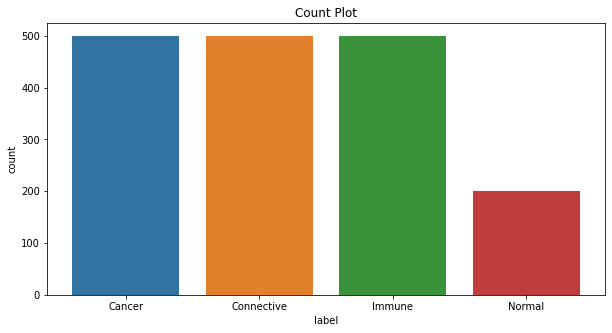

In [8]:
fig=plt.figure(figsize=(10,5))
sns.countplot(data=df_train,x=df_train['label'])
plt.title('Count Plot')
plt.plot()

In [9]:
train_dataset, validation_dataset = torch.utils.data.random_split(dataset_train, (1575,125))

# Create a Train DataLoader using Train Dataset
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4
)
# Create a Validation DataLoader using Test Dataset
validation_dataloader = torch.utils.data.DataLoader(
    dataset=validation_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4
)
# Create a Test DataLoader using Test Dataset
test_dataloader = torch.utils.data.DataLoader(
    dataset=dataset_test,
#     batch_size=16,
    shuffle=False,
    num_workers=4
)

In [10]:
len(test_dataloader)

3200

In [11]:
figsize = (16,16)

def PlotSamples(dataloader, title='Images'):
    sample_data = next(iter(dataloader))[0]
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.title(title)
    plt.imshow(np.transpose(torchvision.utils.make_grid(
        sample_data, padding=2, normalize=True
    ).cpu(), (1,2,0)))

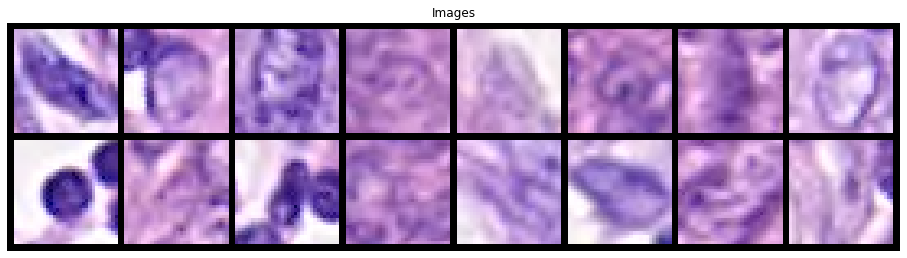

In [12]:
#plot training images
PlotSamples(train_dataloader)

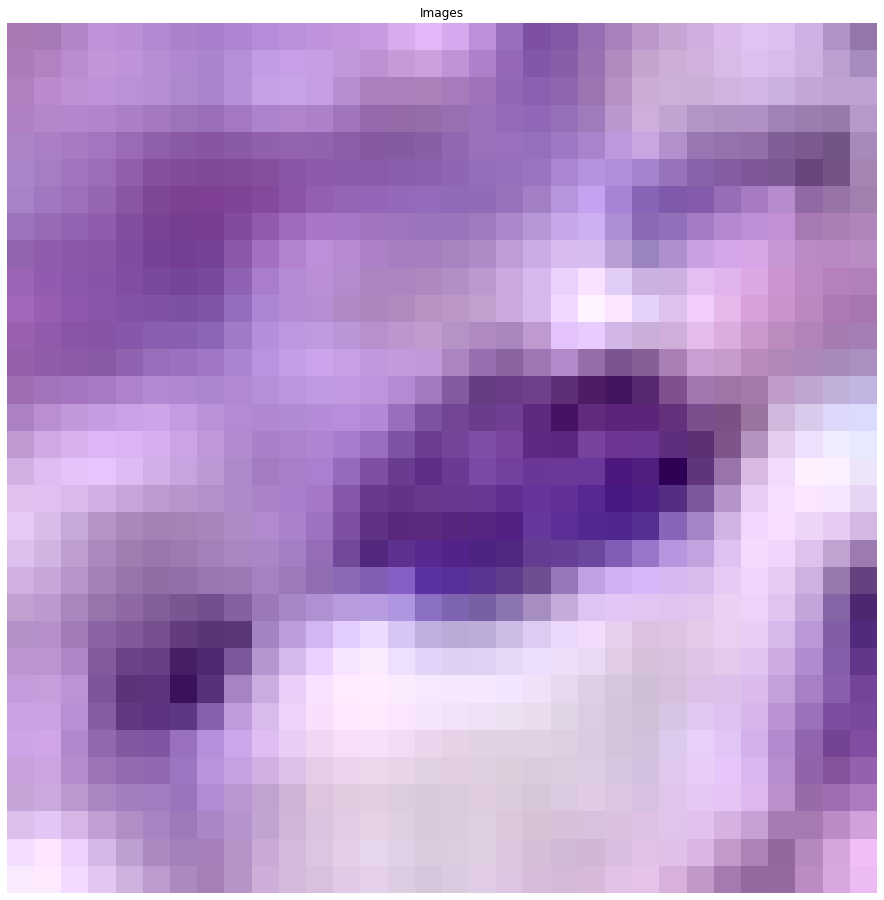

In [13]:
##plot testing image
PlotSamples(test_dataloader)

In [14]:
#CNN model

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 12)
        self.fc1 = nn.Linear(16,120)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
       # print(X.shape)
        X = X.view(-1, 16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return X

In [15]:
model = CNN()

#SGD optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

#Adam optimizer
# criterion = nn.CrossEntropyLoss()#Class weighting
# optimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.01)

#Defining No of epochs
n_epoch = 10

losses = []
print('Model training')
for epoch in range(n_epoch): 
    running_loss = 0.0
    for i, (X_train, y_train) in enumerate(train_dataloader):

        #Forward pass
        y_pred = model(X_train)
        loss = criterion(y_pred,y_train)

        #Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print statistics
        losses.append(loss.detach().numpy())
        running_loss += loss.item()
        if i % 100 == len(train_dataloader)-1:
            print('[%d, %5d] loss: %.10f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Model Trained')

Model training
[1,    99] loss: 0.0655714379
[2,    99] loss: 0.0300460191
[3,    99] loss: 0.0248753525
[4,    99] loss: 0.0215272885
[5,    99] loss: 0.0198540983
[6,    99] loss: 0.0183246940
[7,    99] loss: 0.0174071984
[8,    99] loss: 0.0160085066
[9,    99] loss: 0.0156925382
[10,    99] loss: 0.0147839686
Model Trained


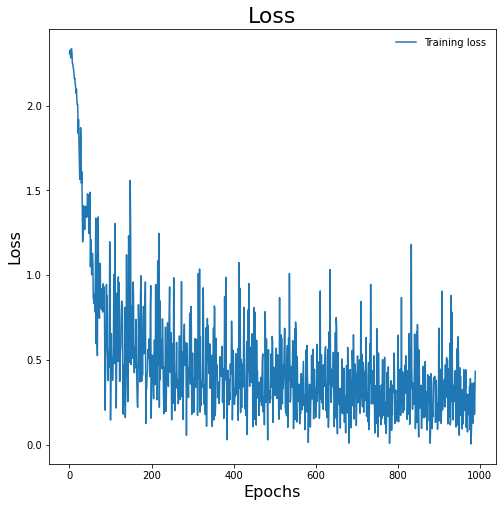

In [16]:
#plot Loss curves
plt.figure(figsize=(8,8))
plt.title('Loss', fontsize=22)
plt.plot(losses, label='Training loss')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(frameon=False)
plt.show()

In [18]:
#Calculate accuracy for validation dataset
pred_sum = 0
lable_sum = 0
with torch.no_grad():
    for X_train, y_train in validation_dataloader:
#         images, labels = data
        outputs = model(X_train)
        _, predicted = torch.max(outputs.data, 1)
        lable_sum += y_train.size(0)
        pred_sum += (predicted == y_train).sum().item()

print('Validation Accuracy: ',(100 * pred_sum / lable_sum))

Validation Accuracy:  86.4


In [19]:
#Predicting labels on test dataset
img_id = []
type_pred=[]
with torch.no_grad():
    for i, (images, labels) in enumerate(test_dataloader,0):
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        npred = pred.tolist()
        type_pred.extend(npred)
        imgid, _ = test_dataloader.dataset.samples[i]
        img_id.append(imgid.split('/')[-1])        
        


In [20]:
#Creating final dataframe with two columns id and type as described in provided "example.csv"
submission_df = {'id':img_id, 'type':type_pred}
submission_df['id'] = [e[10:] for e in submission_df['id']]
submission = pd.DataFrame(submission_df)

In [21]:
#Label mapping 'Cancer': 0, 'Connective': 1, 'Immune': 2, 'Normal': 3
submission['type'] = submission['type'].map(target)
submission.to_csv("submission.csv",index=False)